In [24]:
%load_ext autoreload
%autoreload 2
from math import pi as π
import numpy as np
from astropy import units as u
from freqandsee.freqandsee import WhiteNoise, MovingAverageFilter
from freqandsee.freqandsee import AllanFilter, FilterBank
from freqandsee.project_logger import logger


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
n = int(1e5)
fs = 1 * u.kHz
ts = 1 / fs
time = np.arange(0, n + 1) * ts

White noise type, the PSD is one-sided. This will give a white noise,
bandlimited to $[0,f_s/2]$, with a PSD
of $4*10^{-3} V^2/Hz$.

$$
    \begin{align*}
    t_s &= \frac{1}{f_s}=10^{-3}s\\
    V_{rms} &= \sqrt{\frac{S}{2t_s}}=\sqrt{\frac{4*10^{-3}}{2*10^{-3}}}=\sqrt{2}\;V=1.41V
    \end{align*}
$$

In [26]:
white_noise = WhiteNoise(
    psd=4e-3 * u.volt**2 / u.hertz,
    x=time,
    unit=u.volt,
    name="Resistor white noise",
    x_name="time",
    y_name="voltage",
)
print(f"{white_noise}")

Signal name: 'Resistor white noise' V(kHz⁻¹). n=1.00e+05 sampling points, fs=1.0 kHz, RMS=1.41e+00 V.


<Axes: title={'center': 'Resistor white noise'}, xlabel='time ($\\mathrm{ms}$)', ylabel='voltage ($\\mathrm{V}$)'>

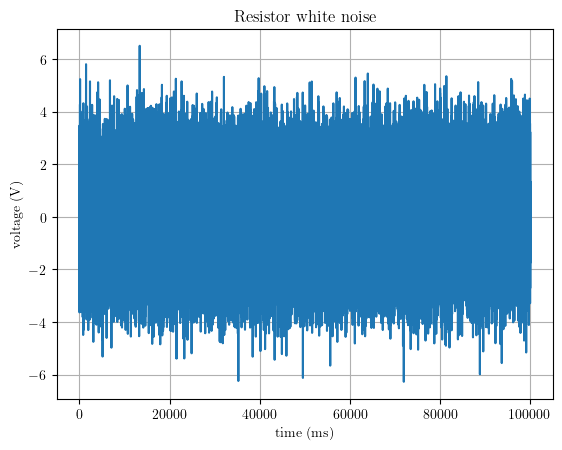

In [27]:
white_noise.plot(x_display_unit=u.ms)

Sanity-checking directly

In [28]:
np.std(white_noise.y)

<Quantity 1.4147718 V>

Can also check with the rms property

In [29]:
white_noise.rms

<Quantity 1.41477193 V>

Get the PSD and check Parseval-Plancherel

In [30]:
s = white_noise.psd()
np.sqrt(sum(s.y) * s.xs)

<Quantity 1.41261655 V>

<Axes: title={'center': 'PSD of Resistor white noise'}, xlabel='Frequency ($\\mathrm{kHz}$)', ylabel='PSD(Resistor white noise) ($\\mathrm{V^{2}\\,kHz^{-1}}$)'>

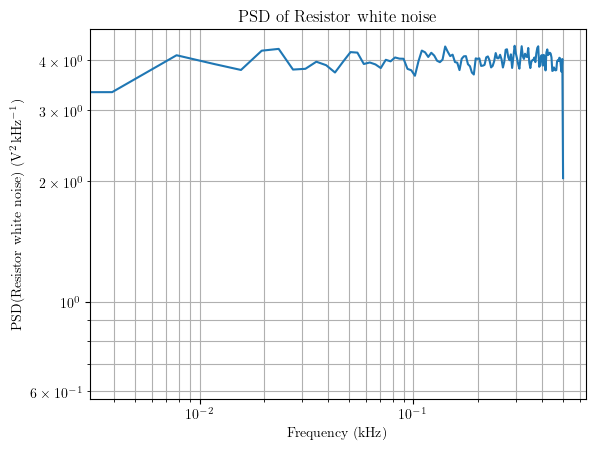

In [31]:
s.plot()

<Axes: title={'center': 'Frequency response, Allan filter (n=4), fs=1.0 kHz'}, xlabel='Frequency ($\\mathrm{kHz}$)', ylabel='$|H(j2\\pi f)|$ $\\mathrm{}$'>

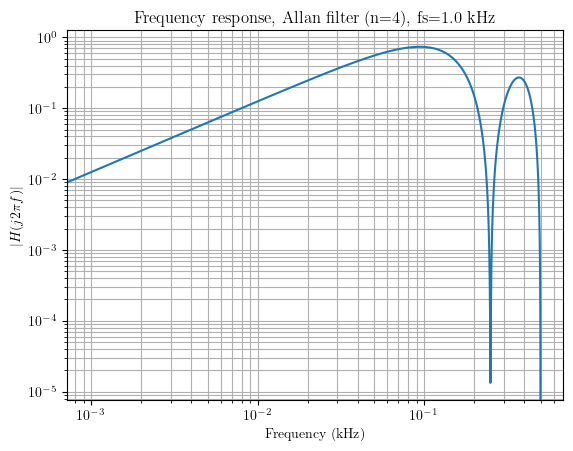

In [32]:
allan_filter = AllanFilter(n=4)
allan_filter.frequency_response(fs=1 / ts).plot(x_display_unit=u.kHz)

In [33]:
z = white_noise * allan_filter
z.name = "filtered white noise"

Create a filter bank with Allan filters of doubling lengths

In [34]:
filter_bank = FilterBank(
    filters=[AllanFilter(n=2 ** (2 * k)) for k in range(3)],
    name="Filter bank",
)

Filter the white noise by the filter bank, and get the rms values for the resulting signal bundle, check that the allan variance is inversly proporional to the MA length.

In [35]:
z_bundle = filter_bank * white_noise
[signal.rms for signal in z_bundle.signals]

[<Quantity 1.00125184 V>, <Quantity 0.50017025 V>, <Quantity 0.24922784 V>]

AttributeError: 'Axes' object has no attribute 'set_x_label'

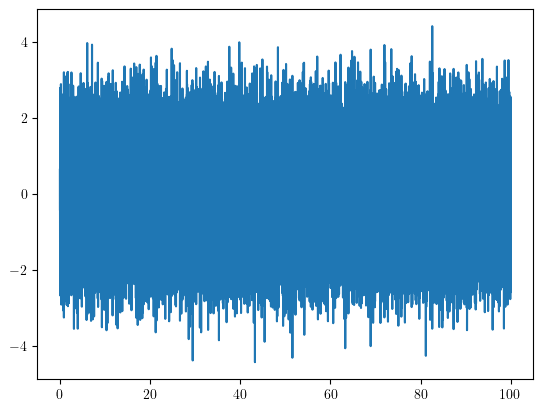

In [37]:
z_bundle.plot(
    all_in_one=True,
    y_label="$y$",
    x_label=f"$t ({u.volt.to_string()})$",
    x_display_unit=u.s,
    y_display_unit=u.volt,
)